# Алгоритмы анализа данных
## Урок 5. Случайный лес

In [1]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np

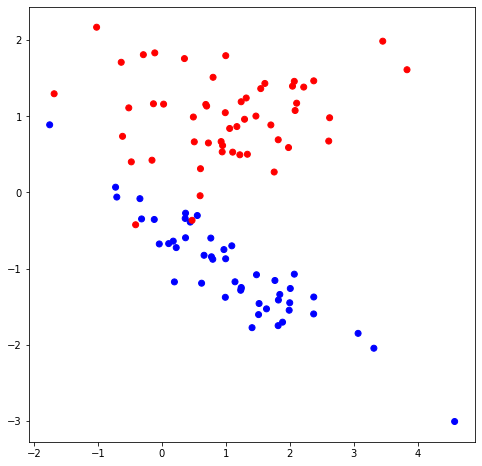

In [56]:
# сгенерируем данные, представляющие собой 500 объектов с 5-ю признаками
classification_data, classification_labels = datasets.make_classification(n_samples=100,
                                                      n_features = 2, n_informative = 2, 
                                                      n_classes = 2, n_redundant=0, 
                                                      n_clusters_per_class=1, random_state=3)
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(np.transpose(classification_data)[0], np.transpose(classification_data)[1], c=classification_labels, cmap=colors)
plt.show()

In [58]:
# Разобьем выборку на обучающую и тестовую

from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                                                     classification_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

In [11]:
random.seed(42)

def get_bootstrap(data, labels, N):
    n_samples = data.shape[0]
    bootstrap = []
    
    for i in range(N):
        b_data = np.zeros(data.shape)
        b_labels = np.zeros(labels.shape)
        
        for j in range(n_samples):
            sample_index = random.randint(0, n_samples-1)
            b_data[j] = data[sample_index]
            b_labels[j] = labels[sample_index]
        bootstrap.append((b_data, b_labels))
        
    return bootstrap

In [12]:
def get_subsample(len_sample):
    # будем сохранять не сами признаки, а их индексы
    sample_indexes = [i for i in range(len_sample)]
    
    len_subsample = int(np.sqrt(len_sample))
    subsample = []
    
    random.shuffle(sample_indexes)
    for _ in range(len_subsample):
        subsample.append(sample_indexes.pop())
        
    return subsample

In [13]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [14]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction  

In [15]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [16]:
# Расчет качества

def quality(left_labels, right_labels, current_gini):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [17]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [18]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 1

    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    # выбор индекса из подвыборки длиной sqrt(n_features)
    subsample = get_subsample(n_features)
    
    for index in subsample:
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [19]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels):

    quality, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [162]:
def random_forest(data, labels, n_trees):
    forest = []
    bootstrap = get_bootstrap(data, labels, n_trees)
    
    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels))

    return forest

In [21]:
# Функция классификации отдельного объекта

def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [22]:
# функция формирования предсказания по выборке на одном дереве

def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [23]:
# предсказание голосованием деревьев

def tree_vote(forest, data):

    # добавим предсказания всех деревьев в список
    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))
    
    # сформируем список с предсказаниями для каждого объекта
    predictions_per_object = list(zip(*predictions))
    
    # выберем в качестве итогового предсказания для каждого объекта то,
    # за которое проголосовало большинство деревьев
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))
        
    return voted_predictions

In [25]:
# Введем функцию подсчета точности как доли правильных ответов

def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

### Задание 1

Сформировать с помощью `sklearn.make_classification` датасет из $100$ объектов с двумя признаками, обучить случайный лес из $1$, $3$, $10$ и $50$ деревьев и визуализировать их разделяющие гиперплоскости на графиках (по подобию визуализации деревьев из предыдущего урока, необходимо только заменить вызов функции `predict` на `tree_vote`). 

Сделать выводы о получаемой сложности гиперплоскости и недообучении или переобучении случайного леса в зависимости от количества деревьев в нем.

**Решение**

In [33]:
def plot_tree(my_tree, train_data, train_labels, train_accuracy, test_data, test_labels, test_accuracy):
    def get_meshgrid(data, step=.05, border=1.2):
        x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
        y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
        return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))
    
    plt.figure(figsize = (16, 7))
    
    # график обучающей выборки
    plt.subplot(1,2,1)
    xx, yy = get_meshgrid(train_data)
    mesh_predictions = np.array(tree_vote(my_tree, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
    plt.title(f'Train accuracy={train_accuracy:.2f}')
    
    # график тестовой выборки
    plt.subplot(1,2,2)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
    plt.title(f'Test accuracy={test_accuracy:.2f}')
    plt.show()

In [163]:
def train_by_trees_n(n_trees, plot=True):
    my_forest = random_forest(train_data, train_labels, n_trees)
    # Получим ответы для обучающей выборки 
    train_answers = tree_vote(my_forest, train_data)
    # И получим ответы для тестовой выборки
    test_answers = tree_vote(my_forest, test_data)
    # Точность на обучающей выборке
    train_accuracy = accuracy_metric(train_labels, train_answers)
    print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')
    # Точность на тестовой выборке
    test_accuracy = accuracy_metric(test_labels, test_answers)
    print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')
    if plot:
        # Визуализируем дерево на графике
        plot_tree(my_forest, train_data, train_labels, train_accuracy, test_data, test_labels, test_accuracy)

Точность случайного леса из 1 деревьев на обучающей выборке: 98.571
Точность случайного леса из 1 деревьев на тестовой выборке: 96.667


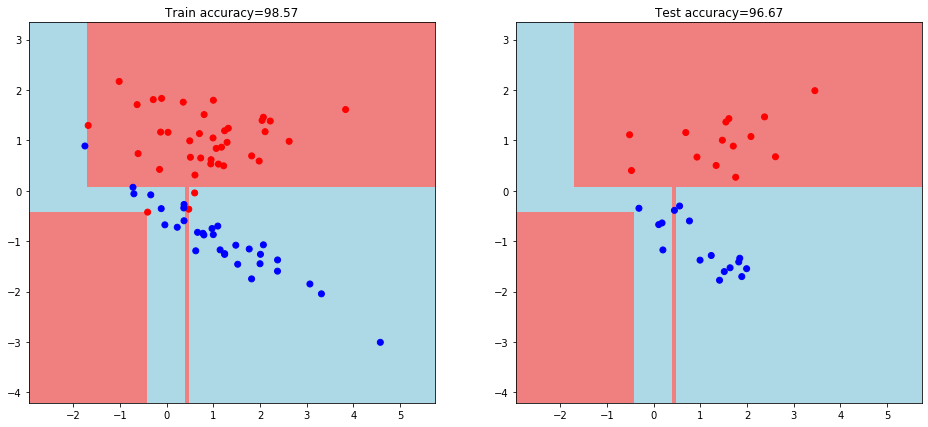

In [164]:
train_by_trees_n(1)

Точность случайного леса из 3 деревьев на обучающей выборке: 97.143
Точность случайного леса из 3 деревьев на тестовой выборке: 93.333


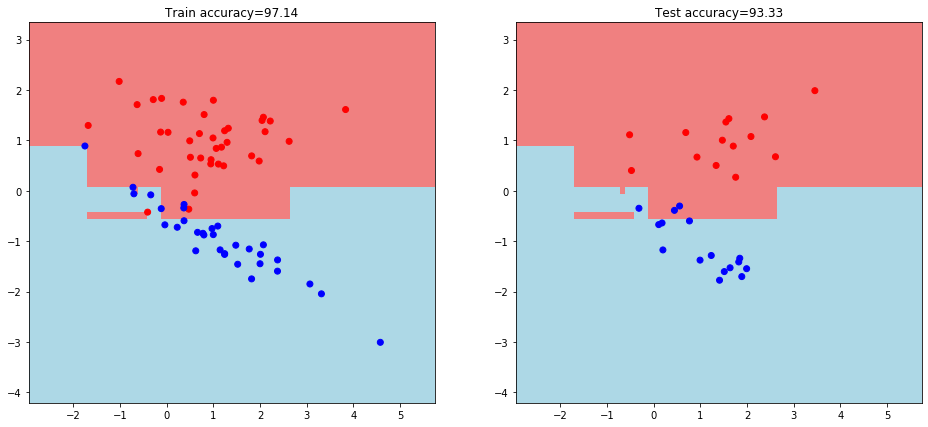

In [165]:
train_by_trees_n(3)

Точность случайного леса из 10 деревьев на обучающей выборке: 100.000
Точность случайного леса из 10 деревьев на тестовой выборке: 93.333


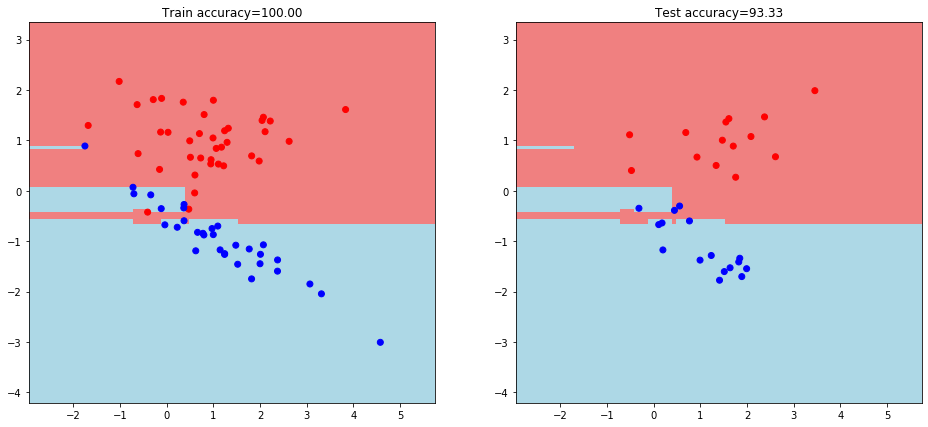

In [60]:
train_by_trees_n(10)

Точность случайного леса из 50 деревьев на обучающей выборке: 100.000
Точность случайного леса из 50 деревьев на тестовой выборке: 96.667


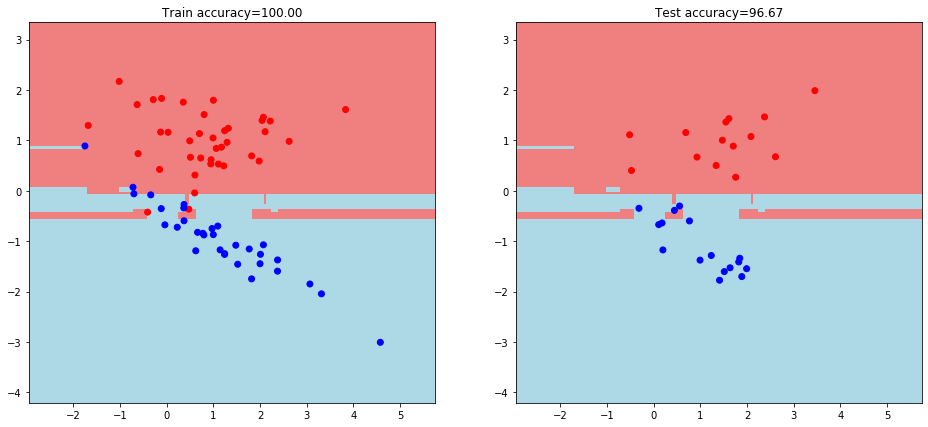

In [59]:
train_by_trees_n(50)

Чем больше деревьев, тем сильнее переобучается модель. Вместо сплошного разделения зон классов мы наблюдаем провалы в этих зонах в точках с выбросами.

### Задание 2*

Заменить в реализованном алгоритме проверку с помощью отложенной выборки на Out-of-Bag.

**Решение**

In [216]:
def random_forest(data, labels, n_trees):
    forest = []
    oob_votes = []
    bootstrap = get_bootstrap(data, labels, n_trees)
    
    for b_data, b_labels in bootstrap:
        tree = build_tree(b_data, b_labels)
        forest.append(tree)
        
        # избавимся от повторов внутри одного набора данных
        uniq_data = set()
        u_data = []
        u_labels = []
        for id, item in enumerate(b_data):
            if (item[0],item[1]) not in uniq_data:
                uniq_data.add((item[0],item[1]))
                u_data.append(item)
                u_labels.append(b_labels[id])
        # предскажем значения для данных, которые не попали на обучение
        out_votes = [predict([u_data[int(x)]], tree)[0] if x == 0 else None for x in u_labels]
        # пометим правильно предсказанные значения 1, а неправильно 0
        out_predicted = []
        for i, item in enumerate(out_votes):
            if item is None:
                out_predicted.append(None)
            elif item == b_labels[i]:
                out_predicted.append(1)
            else:
                out_predicted.append(0)
        # отфильтруем данные, для которых не делали предсказания
        out_predicted = list(filter(lambda x: x is not None, out_predicted))
        # поместим результат в список? или найдём точность для данной модели?
#         oob_votes.append(out_predicted)
        oob_votes.append(sum(out_predicted) / len(out_predicted))
    
#     oob_votes = [x for sublist in oob_votes for x in sublist]
    oob = sum(oob_votes) / len(oob_votes)
    print('oob =', oob)
    return forest

In [217]:
train_by_trees_n(1, plot=False)
train_by_trees_n(3, plot=False)
train_by_trees_n(10, plot=False)
train_by_trees_n(50, plot=False)

oob = 0.8333333333333334
Точность случайного леса из 1 деревьев на обучающей выборке: 94.286
Точность случайного леса из 1 деревьев на тестовой выборке: 80.000
oob = 0.44341723874904654
Точность случайного леса из 3 деревьев на обучающей выборке: 97.143
Точность случайного леса из 3 деревьев на тестовой выборке: 93.333
oob = 0.40953550153550156
Точность случайного леса из 10 деревьев на обучающей выборке: 100.000
Точность случайного леса из 10 деревьев на тестовой выборке: 96.667
oob = 0.5650016367409816
Точность случайного леса из 50 деревьев на обучающей выборке: 100.000
Точность случайного леса из 50 деревьев на тестовой выборке: 96.667


### Задание 3* (На повторение)

Переписать функцию `calc_gini` из урока про решающие деревья так, чтобы в качестве критерия использовалась энтропия Шэннона. Переименовать функцию в `calc_entropy`.

**Решение**

In [254]:
# Расчет энтропии Шэннона
from collections import Counter


def entropy(labels):
    #  подсчет количества объектов разных классов
    classes = Counter(labels)
    
    #  расчет энтропии
    impurity = 0
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p * np.log2(p)
        
    return impurity

In [255]:
labels3 = [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
print('For', labels3, ':')
print('gini =', gini(labels3))
print('entropy =', entropy(labels3))

For [0, 0, 0, 0, 0, 0, 0, 0, 0, 1] :
gini = 0.17999999999999994
entropy = 0.4689955935892812


In [256]:
labels3 = [0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
print('For', labels3, ':')
print('gini =', gini(labels3))
print('entropy =', entropy(labels3))

For [0, 0, 0, 0, 0, 1, 1, 1, 1, 1] :
gini = 0.5
entropy = 1.0


In [257]:
labels3 = [0, 1, 1, 1, 1, 1, 1, 1, 1, 1]
print('For', labels3, ':')
print('gini =', gini(labels3))
print('entropy =', entropy(labels3))

For [0, 1, 1, 1, 1, 1, 1, 1, 1, 1] :
gini = 0.17999999999999994
entropy = 0.4689955935892812
